In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import datetime
import math
import matplotlib.pyplot as plt
from scipy import stats
%pylab inline
import seaborn as sns

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

#s = json.load( open(os.getenv('PUI2018') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2018


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## IDEA:
## Young people move longer distances than people other ages do by Citibike.

## NULL HYPOTHESIS:
## In average, young people (age - 30) move same or shorter distances than people other ages group (age 31-) do by Citibike.

## ALTERNATIVE HYPOTHESIS:
## In average, young people (age - 30) move significantly longer distances than people other age group (age 31-) do by Citibike.

# _$H_0$_ : $\frac{O_{\mathrm{total-distance}}}{O_{\mathrm{tripnumber}}} <= \frac{Y_{\mathrm{total-distance}}}{Y_{\mathrm{tripnumber}}}$
# _$H_1$_ : $\frac{O_{\mathrm{total-distance}}}{O_{\mathrm{tripnumber}}} > \frac{Y_{\mathrm{total-distance}}}{Y_{\mathrm{tripnumber}}}$


## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [2]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 


In [5]:
# Age
now=datetime.datetime.now()
df['datenow']=now.year
df['age'] = df['datenow'] - df['birth year']

# Distance
Latdiff= df['start station latitude'] - df['end station latitude'] 
Longdiff= df['start station longitude'] - df['end station longitude'] 
Distancesq= Latdiff**2 + Longdiff **2
df['distance'] = np.sqrt(Distancesq)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,datenow,age,distance
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00,2018,58.0,0.035658
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00,2018,55.0,0.005786
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00,2018,44.0,0.008417
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00,2018,49.0,0.005471
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00,2018,41.0,0.019191


In [6]:
df.columns

# Age -30 and -31
df['age_30']=df['age']<=30
df.drop(df.index[df['age'] >=100 ], inplace=True)


In [7]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year','gender','date','datenow'], axis=1, inplace=True)

In [8]:
pd.to_numeric(df['age'])
df.head(10)


,age,distance,age_30
0,58.0,0.035658,False
1,55.0,0.005786,False
2,44.0,0.008417,False
3,49.0,0.005471,False
4,41.0,0.019191,False
5,49.0,0.014953,False
6,46.0,0.003606,False
7,33.0,0.030754,False
8,27.0,0.008241,True
9,27.0,0.010104,True


### Lets plot the trip distances by age

38452
246979


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


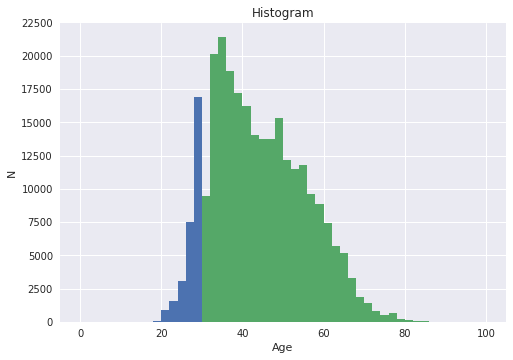

In [9]:
ind=(df.age_30==1)
print(sum(ind))
dfUnder30=df.loc[ind]

ind2=(df.age_30==0)
print(sum(ind2))
dfOver30=df.loc[ind2]

#int(df['age'])

matplotlib.pylab.hist(dfUnder30['age'],bins=50,range=(0, 100))
matplotlib.pylab.hist(dfOver30['age'],bins=50,range=(0, 100))

pl.ylabel('N')
pl.xlabel('Age')
pl.title("Histogram")


### Figure 1: 
Figure 1 show the age(x axis) and N(y axis) of Citibike data in 01/2015. It shows that age around 35 has lots of samples. 


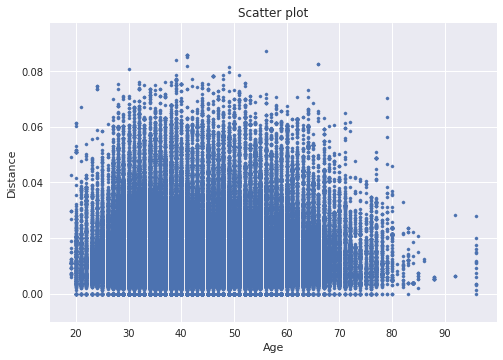

In [10]:
plt.scatter(df['age'],df['distance'],s=10)
pl.ylabel('Distance')
pl.xlabel('Age')
pl.title("Scatter plot")
# ax1 = df.plot.scatter (x=1, y=1,c='DarkBlue')

### Figure 2: 
Figure 2 show the age(x axis) and N(y axis) of Citibike data in 01/2015. It shows that age around 40 has a lots of samples which moved long distances
. 


In [11]:
dfOver30.dropna(inplace=True)
dfUnder30.dropna(inplace=True)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
print(dfOver30.distance.mean())
print(dfUnder30.distance.mean())


0.014885748757
0.0143949716096


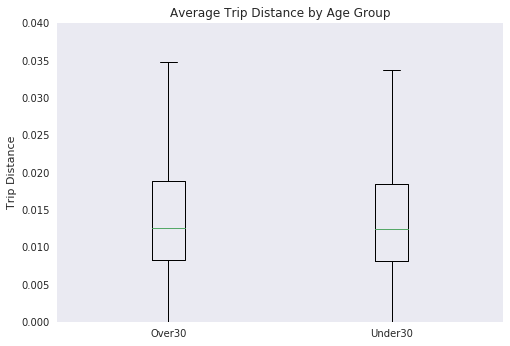

In [13]:
points = (dfOver30.distance, dfUnder30.distance)
fig, ax = plt.subplots()
bp = ax.boxplot(points)
ax.set_xticklabels(['Over30', 'Under30'])

plt.title('Average Trip Distance by Age Group')
plt.ylabel('Trip Distance')
plt.ylim([0,0.04])
plt.grid()
plt.show()

### Figure 3: 
Figure 3 shows average trip distance by age group. The average for Over30 is 0.01488 and Under30 is 0.01439, meaning the difference is too small to see in this graph. 

## My referee recommended me to carry out t-test and I agree with the opinion because
- We compare the means of two samples. 
- We can use parametric test as the population is large enough.

## Also, we should choose t-test (independent) instead of t-test (paired)

## However, now we need to re-think our H1 hypothesis 'younger people move longer distance', which is not true in terms of the average trip distance in our sample. On the contrary, Average Distance: Old = 0.01488, Young = 0.01439.

## If we do T-test and get significant figures, that means older group has significantly longer average trip distance than that of younger group. 

In [14]:
ttest = stats.ttest_ind(dfOver30.distance, dfUnder30.distance)
ttest

Ttest_indResult(statistic=9.1326787555660225, pvalue=6.725145754446088e-20)

## According to the t-test, the two samples have significant difference in trip distance. But, this does not mean our initial H1 hypothesis is true, rather H1 is not true (Average Distance: Old = 0.01488, Young = 0.01439). 
## We can not reject our initial null hypothesis.


## If we set Null Hypothesis like below, we could have said 'Older group has longer average trip distance than that of younger.'


_$H_0$_ : $\frac{Old_{\mathrm{total-distance}}}{Old_{\mathrm{tripnumber}}} <= \frac{Young_{\mathrm{total-distance}}}{Young_{\mathrm{tripnumber}}}$


_$H_1$_ : $\frac{Old_{\mathrm{total-distance}}}{Old_{\mathrm{tripnumber}}} > \frac{Young_{\mathrm{total-distance}}}{Young_{\mathrm{tripnumber}}}$

## However, we should be hypothesis driven and we should not change the hypothesis after diving into analysis part. The result we got is contradict with my intuition though. 

## Robustness check
## We will do the same analysis using different sample. 

In [15]:
datestring = '201506'
getCitiBikeCSV(datestring)
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
# Age
now=datetime.datetime.now()
df['datenow']=now.year
df['age'] = df['datenow'] - df['birth year']

# Distance
Latdiff= df['start station latitude'] - df['end station latitude'] 
Longdiff= df['start station longitude'] - df['end station longitude'] 
Distancesq= Latdiff**2 + Longdiff **2
df['distance'] = np.sqrt(Distancesq)
df.head()

file in place, you can continue


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,datenow,age,distance
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1,2015-06-01 00:00:00,2018,34.0,0.035252
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1,2015-06-01 00:00:00,2018,21.0,0.006700
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1,2015-06-01 00:01:00,2018,25.0,0.014726
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1,2015-06-01 00:01:00,2018,37.0,0.002978
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,2015-06-01 00:02:00,2018,NaN,0.039599


In [16]:
df.columns

# Age -30 and -31
df['age_30']=df['age']<=30
df.drop(df.index[df['age'] >=100 ], inplace=True)
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year','gender','date','datenow'], axis=1, inplace=True)

135627
805334


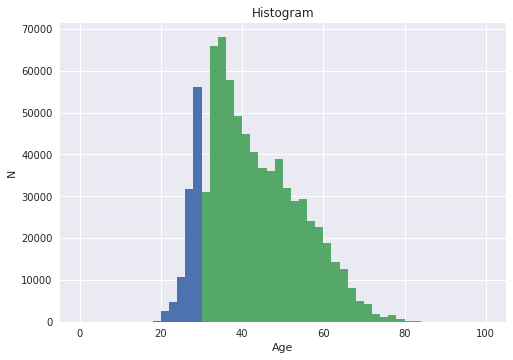

In [17]:
pd.to_numeric(df['age'])
df.head(10)
ind=(df.age_30==1)
print(sum(ind))
dfUnder30=df.loc[ind]

ind2=(df.age_30==0)
print(sum(ind2))
dfOver30=df.loc[ind2]

#int(df['age'])

matplotlib.pylab.hist(dfUnder30['age'],bins=50,range=(0, 100))
matplotlib.pylab.hist(dfOver30['age'],bins=50,range=(0, 100))

pl.ylabel('N')
pl.xlabel('Age')
pl.title("Histogram")

In [18]:
dfOver30.dropna(inplace=True)
dfUnder30.dropna(inplace=True)
print(dfOver30.distance.mean())
print(dfUnder30.distance.mean())


0.0171540926984
0.0171354932533


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
ttest = stats.ttest_ind(dfOver30.distance, dfUnder30.distance)
ttest

Ttest_indResult(statistic=0.53585450799241696, pvalue=0.5920592540844446)

## This time, we did not get significant difference between old and young group in trip distance while older group has longer average trip distance again. Therefore, the new null hypothesis 'younger group has same or longer trip distance than that of older' is not rejected from this sample.

##  1. *verify that their Null and alternative hypotheses are formulated correctly* 
1.1. The null and alternative hypotheses are correct and testable. 

1.2. The formula is a bit confusing. Instead of

_$H_0$_ : $\frac{O_{\mathrm{total-distance}}}{O_{\mathrm{tripnumber}}} <= \frac{Y_{\mathrm{total-distance}}}{Y_{\mathrm{tripnumber}}}$

a better way will be:

_$H_0$_ : $\frac{Total Distance_{\mathrm{old}}}{Trip Counts_{\mathrm{old}}} <= \frac{Total Distance_{\mathrm{young}}}{Trip Counts_{\mathrm{young}}}$ 

## 2. verify that the data supports the project
2.1. The data you extracted can be used to support your research. 

2.2. I will suggest you to make titles of the graphs more meaningful. For example, instead of naming a histogram "Histogram", name the graph "Trip Count Distribution by Age." 

2.3. The graphs does not explore the hypothesis far enough though. I will suggest you to slip your sample group into two groups by age, and compare their average distance.

## 3. chose an appropriate test to test H0 given the type of data, and the question asked

3.1. Since you are comparing two unpaired sample groups, which means that you are looking for the significance of the difference between the groups, I will suggest you to run the t test.
